In [1]:
import pandas as pd

ground_truth = pd.read_csv("../sp-week-9/ground truth dataset.csv")
ground_truth.sample(3)

,text,ent_1,label_1,ent_2,label_2
0,"Good morning. As you said, I'm a downtown resi...",NaN,NaN,NaN,NaN
5,"Good afternoon, Council. Thank you for the cha...",Christy Heffaker. And I have proudly worked fo...,PERSON-AFFLIATED-WITH-ORG,NaN,NaN
6,"Good morning, Pete her. Good morning. I'm in d...",NaN,NaN,NaN,NaN


In [2]:
import segeval

def _get_segmentation_for_ground_truth(row: pd.Series) -> tuple[int, ...]:
    boundary_indices = []
    
    # Get start and end index of each ent
    if isinstance(row.ent_1, str):
        boundary_indices.append(row.text.index(row.ent_1))
        boundary_indices.append(len(row.ent_1))
    if isinstance(row.ent_2, str):
        boundary_indices.append(row.text.index(row.ent_2))
        boundary_indices.append(len(row.ent_2))
    
    # Get string
    seg_string = ""
    for i in range(len(row.text)):
        if i in boundary_indices:
            seg_string += "1"
        else:
            seg_string += "0"
    
    return segeval.convert_nltk_to_masses(seg_string)

# Apply
ground_truth["ground_truth_seg"] = ground_truth.apply(_get_segmentation_for_ground_truth, axis=1)
    
# We really only need to store the text, and the masses
comparison_df = pd.DataFrame([ground_truth.text, ground_truth.ground_truth_seg]).T
comparison_df.sample(5)

,text,ground_truth_seg
19,"My name is Gamila, I have times and I'm an Org...","(12, 23, 33, 921, 1456)"
4,"Yes, I'm here. I'm unmuted, it appears. Yes. O...","(253,)"
0,"Good morning. As you said, I'm a downtown resi...","(314,)"
22,My name is Juanita Douglas t senior constructi...,"(12, 96, 710)"
9,Good morning. I want to address your agenda it...,"(724,)"


In [3]:
import pickle

with open("../trial-pc-intro-classifier/stored-classifier.pkl", "rb") as open_f:
    classifier = pickle.load(open_f)

window_size = 20
stride = 4
tolerence = 2

def _get_segmentation_for_classifier(text: str) -> tuple[int, ...]:
    words = text.split()
    found_intros = []
    current_classification_content = []
    current_tol = 0
    for w_i in range(0, len(words) - window_size + 1, stride):
        # Get current window
        windowed_words = words[w_i: w_i + window_size]
        content = " ".join(windowed_words)
        
        # Pred
        pred = classifier.predict([content])
        
        # handle intro pred
        if pred == "comment-intro":
            # chop everything off except last stride
            if len(current_classification_content) != 0:
                current_classification_content.append(" ".join(windowed_words[-stride:]))
            # if first one, add it all
            else:
                current_classification_content.append(content)
        
        # handle end of pred
        else:            
            # handle existing pred
            if len(current_classification_content) != 0:
                # handle tolerance
                if current_tol < tolerence:
                    current_classification_content.append(" ".join(windowed_words[-stride:]))
                    current_tol += 1
                else:
                    joined_content = " ".join(current_classification_content)
                    found_intros.append(joined_content)
                    current_classification_content = []
    
    # Return no found intros
    if len(found_intros) == 0:
        return (len(text) + 1,)
    
    # Keep track of indicies of interest
    segmentation_indicies = []
    for intro in found_intros:
        # Get the index of this intro and its length
        intro_start_index = text.index(intro)
        intro_len = len(intro)
        segmentation_indicies.append(intro_start_index)
        segmentation_indicies.append(intro_start_index + intro_len)
    
    # Create string
    nltk_seg_string = ""
    for i in range(len(text)):
        if i in segmentation_indicies:
            nltk_seg_string += "1"
        else:
            nltk_seg_string += "0"

    return segeval.convert_nltk_to_masses(nltk_seg_string)

# Apply
comparison_df["classifier_seg"] = comparison_df.text.apply(_get_segmentation_for_classifier)

In [4]:
import spacy

nlp = spacy.load("../local-interest-groups-ner-model-v1/")

def _get_segmentation_for_ner(text: str) -> tuple[int, ...]:
    # Get ents
    doc = nlp(text)
    
    # Get the start and end of the entity
    segmentation_indicies = []
    for ent in doc.ents:
        segmentation_indicies.append(ent.start_char)
        segmentation_indicies.append(ent.end_char)
    
    # Return no found intros
    if len(segmentation_indicies) == 0:
        return (len(text) + 1,)
    
    # Create string
    nltk_seg_string = ""
    for i in range(len(text)):
        if i in segmentation_indicies:
            nltk_seg_string += "1"
        else:
            nltk_seg_string += "0"

    return segeval.convert_nltk_to_masses(nltk_seg_string)

# Apply
comparison_df["ner_seg"] = comparison_df.text.apply(_get_segmentation_for_ner)

In [5]:
# https://segeval.readthedocs.io/en/latest/api/#pk

# Compute classifier pk diff
comparison_df["classifier_pk"] = comparison_df.apply(
    lambda row: float(segeval.pk(row.classifier_seg, row.ground_truth_seg)),
    axis=1,
)

# Compute ner pk diff
comparison_df["ner_pk"] = comparison_df.apply(
    lambda row: float(segeval.pk(row.ner_seg, row.ground_truth_seg)),
    axis=1,
)

In [6]:
comparison_df

,text,ground_truth_seg,classifier_seg,ner_seg,classifier_pk,ner_pk
0,"Good morning. As you said, I'm a downtown resi...","(314,)","(22, 170, 122)","(314,)",0.917197,0.000000
1,Down morning. I'm chair of tree pack. It's dis...,"(423,)","(423,)","(423,)",0.000000,0.000000
2,"So Doug and Andrew if you are out there, call ...","(108, 56, 107)","(271,)","(108, 163)",0.398230,0.199115
3,"Thank you. Hi, I just want to bring attention ...","(34, 141, 433)","(164, 188, 256)","(608,)",0.309665,0.266272
4,"Yes, I'm here. I'm unmuted, it appears. Yes. O...","(253,)","(253,)","(253,)",0.000000,0.000000
5,"Good afternoon, Council. Thank you for the cha...","(72, 15, 317)","(69, 142, 193)","(72, 332)",0.261128,0.044510
6,"Good morning, Pete her. Good morning. I'm in d...","(596,)","(596,)","(596,)",0.000000,0.000000
7,"Jacob, good morning. Hi. I'm Jacob sheer, Orga...","(30, 11, 370)","(411,)","(411,)",0.119534,0.119534
8,"Good morning. I am Madison, resident of distri...","(20, 60, 561)","(1, 214, 426)","(641,)",0.348315,0.149813
9,Good morning. I want to address your agenda it...,"(724,)","(724,)","(724,)",0.000000,0.000000


In [7]:
comparison_df.classifier_pk.describe()

count    28.000000
mean      0.219442
std       0.214632
min       0.000000
25%       0.000000
50%       0.162108
75%       0.350695
max       0.917197
Name: classifier_pk, dtype: float64

In [8]:
comparison_df.ner_pk.describe()

count    28.000000
mean      0.093992
std       0.100220
min       0.000000
25%       0.000000
50%       0.055822
75%       0.156907
max       0.340176
Name: ner_pk, dtype: float64

<Axes: xlabel='value', ylabel='source'>

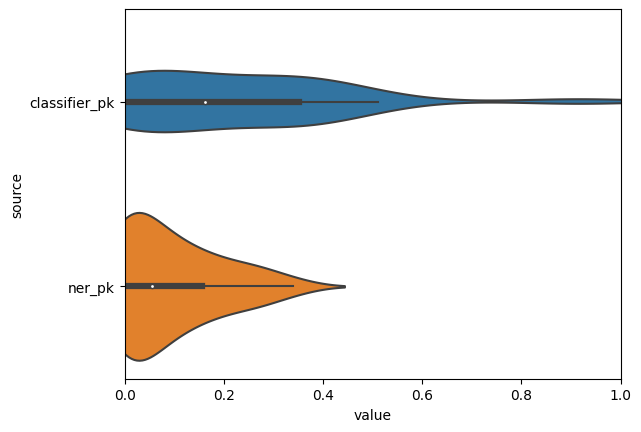

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.xlim([0, 1])

plotting_df = comparison_df.copy()[["classifier_pk", "ner_pk"]]
plotting_df = plotting_df.melt(var_name="source")

sns.violinplot(data=plotting_df, x="value", y="source")

<Axes: xlabel='value', ylabel='source'>

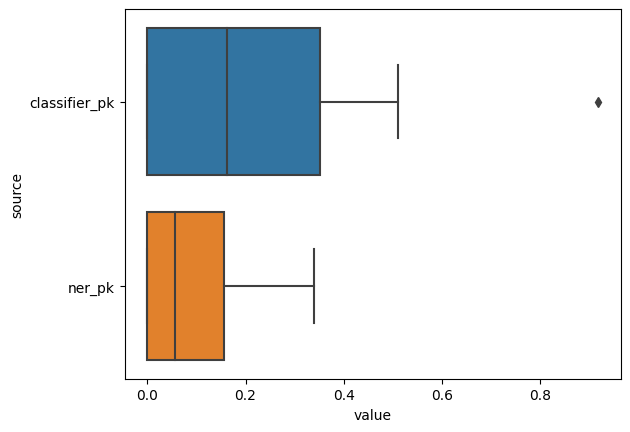

In [10]:
sns.boxplot(data=plotting_df, x="value", y="source")